# Motivation!

The development of third generation detectors like Cosmic Explorer (CE) and Einstein Telescope (ET) marks an exciting new chapter in gravitational wave detection. For one, Cosmic Explorer has a lower sensitivity curve than VIRGO or Advanced LIGO and is capable of detecting gravitational waves at a slightly lower frequency and in a much wider frequency band (here are some numbers, if you're curious: Cosmic Explorer's frequency band starts at $5$ $Hz$ compared to aLIGO/VIRGO/KAGRA's lower limit at $10$ $Hz$. CE's strain sensitivity is better than ~$10^{-23} Hz^{-½}$ starting at ~$5.7$ $Hz$ compared to Advanced LIGO achieving ~$10^{-23} Hz^{-½}$ at ~$100$ $Hz$). These lower frequencies made accesible by CE is |important for detecting intermediate sized BH binaries ranging from ~100M☉ to ~1000M☉ (also include a piece regarding neutron star binaries and maybe black hole neutron star binaries if able)

So the main questions this notebook is trying to address are with regards to both the range/limits of detectable signals by Cosmic Explorer and more generally, the limits of current SXS simulations. For example, for a variety of different spins, eccentricities, etc characterized in various BHBH system, to what limits/ranges of mass and distance are we able to see them with CE? Are current models sufficient enough for matched filtering with possible signals, or are we missing information? SXS currently decomposes gravitational waves strains up to their (8,8) modes - would we need more modes to model a more massive BHBH system with sufficient enough accuracy (and if so, how many more?)? Cosmic Explorer's frequency band starts at a lower frequency - do our SXS simulations need more orbits or are our modelled inspirals long enough? Since the early inspiral is better modeled using Post-Newtonian, more orbits would provide more motivation for joining Post-Newtonian with Numerical Relativity for our simulations.

This notebook is designed to let you see some examples and play around with the masses and distances of various BHBH systems, to see what these BHBH simulations with various mass ratios, eccentricities, and precession look like with respect to the CE noise curve. So let's delve right in!

# Importing and Initializing

Let's start by just importing the necessary packages used in this notebook to run these examples...

In [1]:
%matplotlib ipympl

import re
import sxs
import numpy as np
import bilby
import scipy.interpolate  
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons
import ipywidgets as widgets
from IPython.display import display
import mpl_interactions.ipyplot as iplt
import sxs_iplots as isxs

We should also set some basic constants we need here for all of our calculations later on (G is the gravitational constant, c is the speed of light, M is the mass of the whole binary in kg and r is the distance from the detector to the the binary in meters). Though since kg and m are just a tad inappropriate for the context we are in, we scale M and r to be in the more astronomical units of solar masses (M☉) and megaparsecs (Mpc) respectively (though the 'units' are kept in kg and meters for calculation purposes only). We initialize M to be 33 M☉ and r to be 100 Mpc

<font color='orange'>note to myself: what if we just change the initialized M to be something like 1 for just simplification purposes? Since binary total mass likely can't be as small as 1 solar mass, we could also maybe set it to 5? Unless you want to include examples for NSNS systems in the future, but this is just food for thought. 33 solar masses as the initial mass does feel a little too arbitrary and restrictive, since there's definitely BHBH binaries with a smaller total mass </font>
<font color='magenta'>-j 5/29

In [2]:
# constants
G = 6.67430e-11
c = 3e8
M = 6.563e+31
r = 3.086e24
dt = 1e-4 #np.min(np.diff(h.t))

## Import and create noise curves for LIGO O4 and Cosmic Explorer

Here we download and extract some important data for the Cosmic Explorer noise curve in the frequency domain. We also download the noise curve of the most recent observation run of Advanced Ligo just to compare the two

In [3]:
ce = bilby.gw.detector.psd.PowerSpectralDensity(psd_file = 'CE_psd.txt', asd_file = 'CE_wb_asd.txt')
ligo_o4 = bilby.gw.detector.psd.PowerSpectralDensity(asd_file = 'aLIGO_O4_high_asd.txt')

ce_asd_file = open(ce.asd_file, "r")
ce_asd = ce_asd_file.readlines()
ce_asd_file.close()
ce_asd_amplitude = []; ce_asd_frequency = []
for i in ce_asd:
    split_line = re.split(" |\n", i)
    ce_asd_amplitude.append(float(split_line[0]))
    ce_asd_frequency.append(float(split_line[1]))
#print(ce_asd_frequency)

ligo_o4_asd_file = open(ligo_o4.asd_file, "r")
ligo_o4_asd = ligo_o4_asd_file.readlines()
ligo_o4_asd_file.close()
ligo_o4_asd_amplitude = []; ligo_o4_asd_frequency = []
for i in ligo_o4_asd:
    split_line = re.split(" |\n", i)
    ligo_o4_asd_amplitude.append(float(split_line[0]))
    ligo_o4_asd_frequency.append(float(split_line[1]))
#print(ligo_o4_asd_frequency)

# Varying <span style="color:red">Mass Ratios</span> Examples #

Okay now that that's out of the way let's delve into our examples! This first one will include a brief walk through of what's going on with the calculations behind the code and their (*brief*) explanations. The subsequent examples follow the same process, just using a different simulation for the purposes of seeing what changes with different mass ratios/eccentricities/precessions. At the very bottom there's an included 'choose your own waveform' for you to test out, if you're curious about any particular binary mass ratio, eccentricity, precession, etc (or any of their combinations)! <font color='orange'> note to myself: please don't forget to implement this! <font color='magenta'> -j 5/29

## Example 1(a): BBH:2139 (Mass Ratio: 3)

So first to start off, let's just first load the strain in and cut off the first bit of junk radiation before the surrogate signal even starts. Let's also get some basic information like the mass ratio, precession and eccentricity about the binary system. <font color='orange'> note to myself: maybe it would be better and more clear/useful to include all of the information of the simulated system in a table? <font color='magenta'> -j 5/29

In [4]:
metadata2139, h2139 = isxs.load_strain("BBH:2139")

Mass ratio: 2.9997815645777637 
Reference eccentricity: 1.59e-05 
Reference Chi1_Perp (Precession): 1.3736567760917035e-07 
Reference Chi2_Perp (Precession): 2.9261473481909997e-08


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:2139,False,2.999782,-0.499996,1.373657e-07,2.926147e-08,0.000016,0.000016,1508.0,-1.145556e-07,-9.336963e-08,...,"[-12.222826439485722, 0.0282883695727403, -4.2...",22.793278,22.793278,19.270946,"[, v1.1, v1.2, v1.3, v1.4, v2.0, v3.0]",[],2018-11-21 10:32:32,2018-12-02 01:59:04,2018-12-23 19:45:32,2025-01-28 13:23:39.062272


Just for the sake of the first example, it may be useful to have a visualization of what's going on so far. We've just loaded in a simulation of interest, so let's see what this simulation looks like in the time domain!

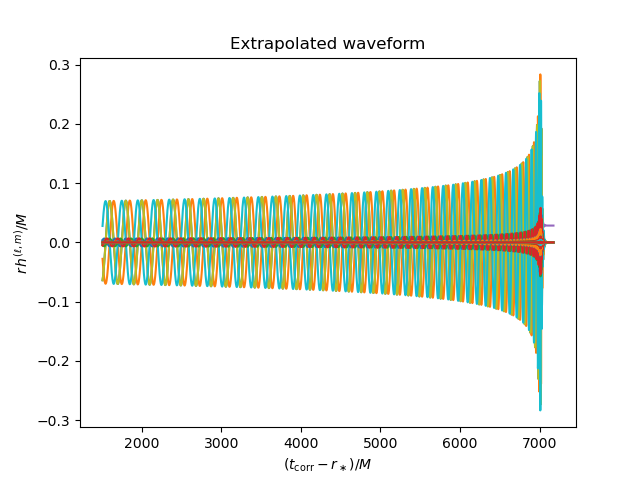

In [5]:
plt.plot(h2139.t, h2139.data.view(float))
plt.title(f"Extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$r\, h^{(\ell,m)}/M$");
plt.draw()

Great! Now notice that the units for the x and y axes aren't quite the same as the units for time nor strain amplitude. You can see in the SXS metadata that there is data for the strain's amplitude and 'time', but they're labeled as something like rhOverM. This is because these 'units' are *actually* unitless. Since it's much more useful to generalize these for any particular strain, time and amplitude are made and saved as dimensionless in the metadata. But for our purposes, we definitely do care about the units so let's revert these back and make them dimensionful.

So for a very very brief explanation on how to do this, let's see what's going on first: When measuring gravitational waves, it's useful to note that the gravitational wave strain $h$ is inversely proportional to the distance $r$ just by $$h \propto \frac{1}{r}$$
But since the universe is quite large, $r$ can be assumed to $$r \rightarrow \infty$$
So, we tend to measure and use the value $rh$ instead (which has units of distance).
Now for simplicity and accuracy, we work in geometrized units, where distance $d$ and time $t$ are written as in terms of constants like $G$, $c$, and $M☉$, so $$d \propto \frac{GM☉}{c^2}$$ and $$t \propto \frac{GM☉}{c^3}$$
Thus, while what LIGO physically sees and measures are indeed $rh$ and $t$, the amplitude strain $H$ and time $T$ that's in the metadata saved in SXS are unitless, where $$H \propto \frac{rh}{\frac{GM☉}{c^2}} \qquad \text{or,} \qquad h \propto \frac{\frac{GM☉}{c^2}}{r} * H$$
and similarly, $$T \propto \frac{t}{\frac{GM☉}{c^3}} \qquad \text{or,} \qquad t \propto \frac{GM☉}{c^3} * T$$

Okay great! Now that we know this, let's dimensionalize our strain's amplitude and time!

In [6]:
h2139, t2139 = isxs.dimensionalize(h2139, G, c, M, r)

Now we can *really* get started with some calculations. Our goal is to compare our surrogate models with aLIGO O4 and Cosmic Explorer's noise curves, so we care more about what our signal looks like in the frequency domain rather than the time domain. So the easiest way to achieve this is to take the Fast Fourier Transform of our signal in the time domain. But before we do that, let's decompose our strain into its (l,m) modes. Because gravitational waves propagate in three dimensions, we model them using spherical harmonics. The lowest mode that SXS goes down to is (8,8) so we decompose our strain into all modes from (8,8) to (2,2) (except the m=0 modes). 

Now we *can* (and will!) take the FFT of all this raw data of every (l,m) mode, but we let's take another additional step for simplification and clarity purposes. The raw data of all these modes together can look quite chaotic and it's nontrivial to slice off all the noise from each mode, so it can be useful to have a way of looking at them without all of the messiness. To get a feel for what the amplitude of each (l,m) mode's Fourier transform looks like, specifically for their amplitudes during inspiral, we can also apply the method of stationary phase to each mode. You can apply the stationary phase approximation (SPA) method whenever you have some arbitrary function $B(t)$ of the form $B(t) = A(t)*\cos(\phi(t))$ where $\dfrac{d\ln A}{dt} \ll \dfrac{d\phi}{dt}$ (or in other words, $A$ varies much slower than $\phi$) and $\omega = 2\pi f = \dfrac{d\phi}{dt}$ is strictly monotonic. Then, you can approximate the Fourier transform of $B(t)$ as $$B(t) \approx A(t(f)) * (\dfrac{df}{dt})^{-\frac{1}{2}}$$
(Or more intuitively, you can think of it as if you have a sinusoid with a rapidly changing phase. If this sinusoid has a region where the phase change is 'slower' - i.e. where the 'stationary phase' is - then this 'slower' region will dominate the Fourier transform integral while the faster, more rapidly changing regions will cancel out and can effectively be ignored.)

Note that this approximation is good for modeling the early stages of a binary's inspiral, but starts to breaks down as the binary approach merger, since the frequency starts to increase more and more dramatically as the two black holes get closer and closer to coalescing. The early phases of the inspiral has a slower orbit, and thus is the location of their stationary phase.

Okay! So to recap: We're interested in looking at and comparing the (l,m) modes of our strain in the frequency domain to the noise curves of aLIGO and CE, so we break down the strain into the (2,2) to (8,8) modes and take the FFT of each. Since the *characteristic* strain is more useful when comparing to detector noise curves, this is what we will plot (we calculate it by multiplying the absolute value of our strain FFT by $\sqrt{f}$). We also find the SPA of all of these modes for a good approximation of what each mode looks like early on in the inspiral. Let's see what all of this finally looks like combined with the noise curves. The code cell below will complete all of the calculations behind the scenes, and run a plot of every mode together with its SPA and the aLIGO/CE noise curves. 

<font color='red'>(AS OF 5/29) Next steps: Finish explaining decomposing the strain into (2,2) to (8,8) modes. Mention how we calculate (2,2) mode first, and scale the frequency and amplitude of all other modes from that one. Also should convince yourself and explain why we don't include the m=0 modes. You can include a plot of all the (l,m) modes in the time domain for visualization. After that, mention how for working in the frequency domain, it's useful to model and measure the amplitude of our modes using the SPA of their respective modes. In particular, it's useful to approximate the earlier inspiral using SPA since the orbits are less frequent. Here you can give a brief explanation of how SPA works. After all this, we take the FFTs of both the actual strain and the SPA of each (l,m) mode and plot them together with also the two noise curves. This is how we see how our current models hold up to the next-gen noise curves (how much can be detected, if not all, and if we need more information like more modes or more orbits).  Then, talk about mass and distance scaling. Then in the next sets of examples you can include respective explanations about precession and eccentricity </font>
<font color='magenta'>-j 5/29

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


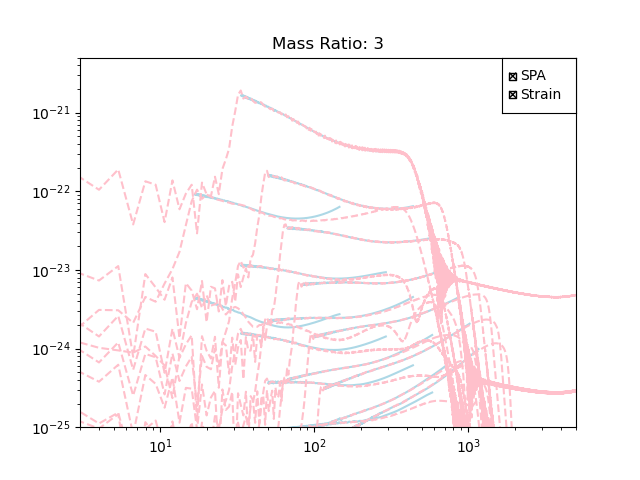

In [7]:
isxs.iplt_lm(h=h2139, t=t2139, metadata=metadata2139, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

<font color=orange> I remember this being pretty annoying to try to implement, but I still think it will be useful to include captions or some sort of label for each (l,m) modes so you can actually see which is which <font color="magenta"> -j 6/3

This plot is interactive, so you can change the mass and distance of this example binary via their respective sliders above the plot! If you're curious about looking at specifically the SPA's or the strains, you can do so via toggling the buttons on the top right. For a very very brief explanation on how the mass and distance scaling works, we let $a$ be the scaling factor for mass $M$ and $b$ be the scaling factor for distance $R$ such that $$M' \rightarrow a*M$$ and $$R' \rightarrow b*R$$

How the frequency of the strain/SPA changes by these scaling factors is relatively simple to see - from our geometrized units time is measured as $$t \propto \frac{GM☉}{c^3}$$
so as $M' \rightarrow a*M$, $$t' = a*t$$
But frequency is the inverse of time, so $$\boxed{f' = \frac{1}{a} *f}$$

To look at the amplitude, recall that $$h = \frac{\frac{GM☉}{c^2}}{r}*H \qquad \text{and} \qquad t = \frac{GM☉}{c^3}*T$$
And that the Fourier transform of strain h is given by $$\tilde{h} = \int h(t)*e^{2\pi ift}dt$$
A factor of $\frac{a^2}{b}$ comes from the $h*dt$ terms. But, since we plot the characteristic strain, we plot $|{\tilde{h}}|\sqrt{f}$, so the final scaling factor ends up being $$\boxed{A' = \frac{a^{3/2}}{b}*A}$$ 

Please feel free to play around with these plots and the sliders to test out various masses and distances! There are also plenty of examples down below (including ones with high precession or high eccentricity), so if you're interested, please check them out! Enjoy!

## Example 1(b): BBH1441 (Mass Ratio: 8)

In [8]:
metadata1441, h1441 = isxs.load_strain("BBH:1441")

Mass ratio: 7.9992725952940305 
Reference eccentricity: 0.0003389 
Reference Chi1_Perp (Precession): 2.0555501711965477e-06 
Reference Chi2_Perp (Precession): 6.726348914708702e-07


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:1441,False,7.999273,0.476256,0.000002,6.726349e-07,0.000339,0.000339,1223.5,0.000002,-1.735402e-07,...,"[-10.416516187951535, 0.0241943347458578, 3.88...",26.538229,26.538229,22.037224,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v2.0, v3.0]",[],2017-04-10 19:01:11,2017-05-30 22:42:14,2017-11-04 22:32:01,2025-01-28 17:52:56.593795


In [9]:
h1441, t1441 = isxs.dimensionalize(h1441, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


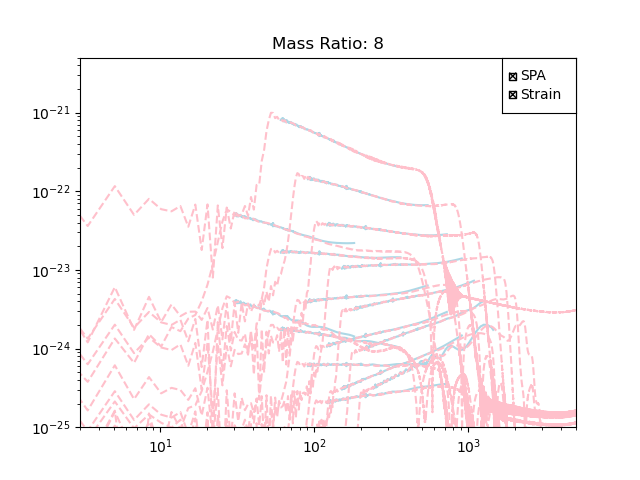

In [10]:
isxs.iplt_lm(h=h1441, t=t1441, metadata=metadata1441)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

## Example 1(c): BBH1107 (Mass Ratio:10)

In [11]:
metadata1107, h1107 = isxs.load_strain("BBH:1107")

Mass ratio: 9.999825891257725 
Reference eccentricity: 0.0010512 
Reference Chi1_Perp (Precession): 1.4718366310402846e-07 
Reference Chi2_Perp (Precession): 4.977031123587994e-08


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:1107,False,9.999826,0.000003,1.471837e-07,4.977031e-08,0.001051,0.001051,500.0,-5.823762e-08,-1.351718e-07,...,"[-11.82606172393236, 0.0130300632761697, 0.0]",30.445153,30.445153,28.895986,"[, v1.2, v1.3, v1.4, v1.5, v2.0, v3.0]",[],2013-09-21 03:59:21,2013-09-22 18:52:50,2013-11-20 15:59:20,2025-02-26 23:49:08.779229


In [12]:
metadata1107.reference_eccentricity

0.0010512

In [13]:
h1107, t1107 = isxs.dimensionalize(h1107, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


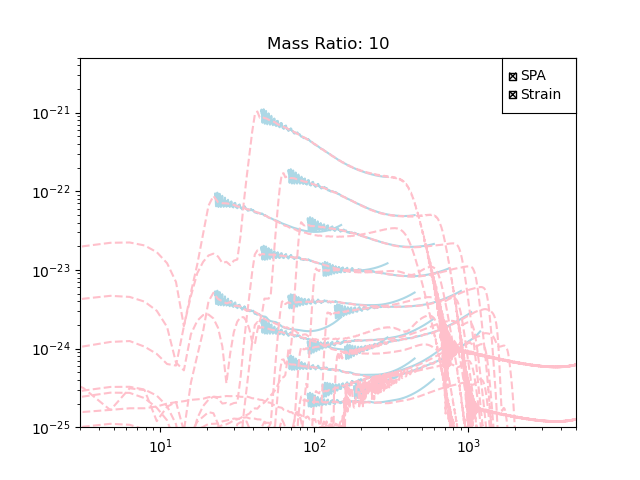

In [14]:
isxs.iplt_lm(h=h1107, t=t1107, metadata=metadata1107)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

## Example 1(d): BBH1154 (Mass Ratio: 1)

In [15]:
metadata1154, h1154 = isxs.load_strain("BBH:1154")

Mass ratio: 1.0000000088810654 
Reference eccentricity: 5.75e-05 
Reference Chi1_Perp (Precession): 8.113241911956016e-09 
Reference Chi2_Perp (Precession): 1.0335726075940603e-08


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:1154,False,1.0,0.000026,8.113242e-09,1.033573e-08,0.000058,0.000058,1277.5,-7.633497e-09,-2.748509e-09,...,"[-10.39514578779858, -1.7797258779e-06, -1.380...",40.651163,40.651163,38.605332,"[, v1.2, v1.3, v1.4, v1.5, v2.0, v3.0]",[],2016-05-17 20:45:52,2016-06-26 11:33:03,2016-10-04 21:26:25,2025-01-28 16:34:50.632280


In [16]:
metadata1154.reference_eccentricity

5.75e-05

In [17]:
h1154, t1154 = isxs.dimensionalize(h1154, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


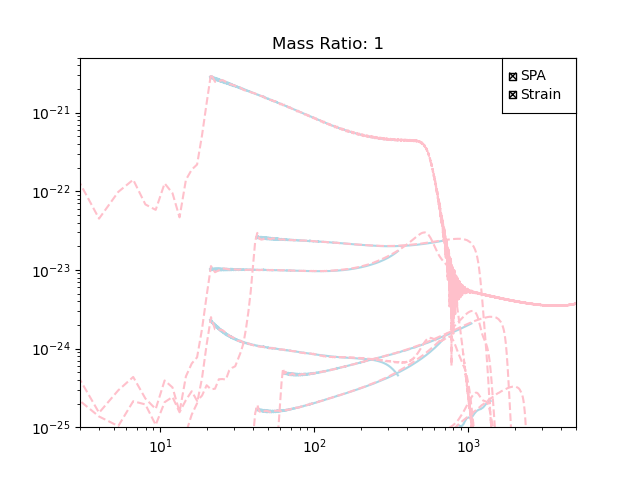

In [18]:
isxs.iplt_lm(h=h1154, t=t1154, metadata=metadata1154, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

# High <span style="color:green">Eccentricity</span> Examples. #

Here are some examples of binaries with high eccentricity. You'll notice that the SPA here isn't particularly useful and can be quite chaotic (or may not even show up). This is because the SPA can only be used if the rate of change of the phase $\phi$ is strictly monotonic (if $f$ is monotonic, we interchange the phase $\phi$ and time $t$ in these cases, so in other words if $t$ is strictly monotonic). But here, frequency will no longer be strictly monotonic, as eccentric orbits imply that the frequency of these orbits at periapsis will be relatively higher than the frequency of apoapsis (so frequencies will vary between these points and there will be more than one time $t$ for a given frequency $f$. 

For some of these plots, you'll notice that the SPA starts to match the strain at higher frequencies close to merger. This is because as the binary approaches merger, the orbits will continue to lose energy to the point where the orbits become less eccentric and more circular.

## Example 2(a): BBH1361 (Mass Ratio: 6; High Eccentricity)

In [13]:
metadata2527, h2527 = isxs.load_strain("BBH:2527")

Mass ratio: 0.9999998703667026 
Reference eccentricity: 0.7988731054686149 
Reference Chi1_Perp (Precession): 7.055731972222282e-09 
Reference Chi2_Perp (Precession): 7.4420589971007364e-09


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:2527,False,1.0,-1.428773e-07,7.055732e-09,7.442059e-09,0.798873,0.798873,1075.0,-4.070683e-09,-5.763012e-09,...,"[-64.99265119946938, -0.0020044052547246, 0.02...",19.918326,19.918326,19.862971,"[, v3.0]",[],2021-02-02 22:01:38,2021-02-03 06:08:34,2021-03-24 18:32:21,2025-01-29 20:56:10.300836


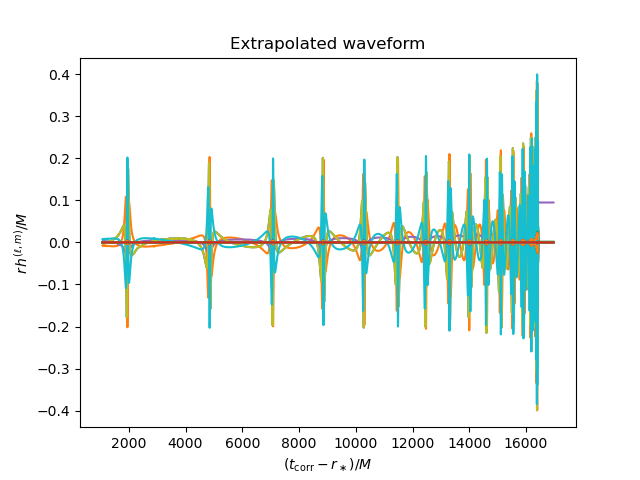

In [14]:
plt.figure()
plt.plot(h2527.t, h2527.data.view(float))
plt.title(f"Extrapolated waveform")
plt.xlabel(r"$(t_{\mathrm{corr}} - r_\ast)/M$")
plt.ylabel(r"$r\, h^{(\ell,m)}/M$");
plt.show()

In [15]:
h2527, t2527 = isxs.dimensionalize(h2527, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


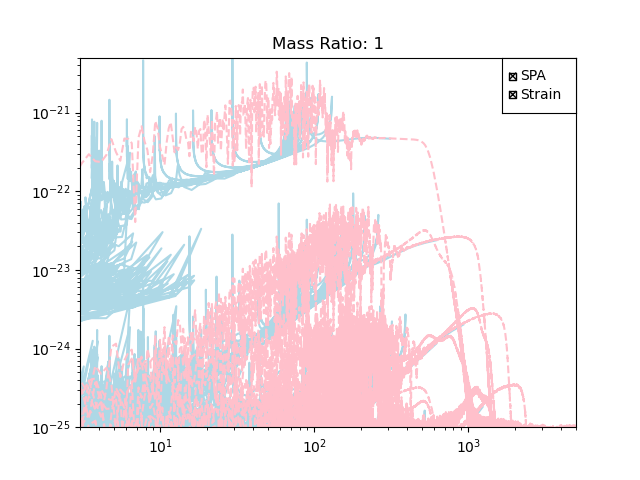

In [16]:
isxs.iplt_lm(h=h2527, t=t2527,metadata=metadata2527, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

## Example 2(b): BBH1360 (Mass Ratio: 1; High Eccentricity)

In [23]:
metadata1360, h1360 = isxs.load_strain("BBH:1360")

Mass ratio: 0.9999998581069992 
Reference eccentricity: 0.2677916373007478 
Reference Chi1_Perp (Precession): 7.024985329761783e-09 
Reference Chi2_Perp (Precession): 6.968899293671746e-09


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:1360,False,1.0,-4.515494e-07,7.024985e-09,6.968899e-09,0.267792,0.267792,290.0,-1.038628e-09,6.947782e-09,...,"[-8.35095711497938, -1.7486244366e-06, -4.0422...",13.136491,13.136491,12.196889,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v2.0, v3.0]",[],2015-11-02 19:41:02,2016-06-09 16:04:12,2016-06-25 03:41:52,2025-01-28 03:27:08.215077


In [24]:
h1360, t1360 = isxs.dimensionalize(h1360, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


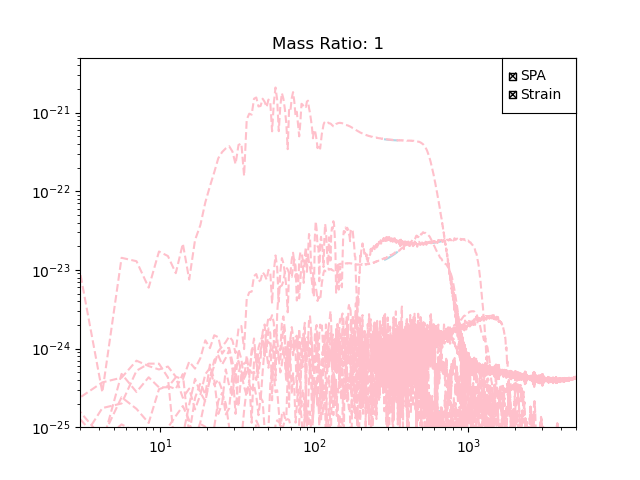

In [25]:
isxs.iplt_lm(h=h1360, t=t1360, metadata=metadata1360, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

where did the SPA go..

## Example 2(c): BBH2612 (Mass Ratio: 1 ; High Eccentricity)

In [20]:
metadata2612, h2612 = isxs.load_strain("BBH:2612")

Mass ratio: 1.000000039894531 
Reference eccentricity: 0.3062990928940375 
Reference Chi1_Perp (Precession): 9.326201768594295e-10 
Reference Chi2_Perp (Precession): 2.1014581286963014e-09


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:2612,False,1.0,-0.000002,9.326202e-10,2.101458e-09,0.306299,0.306299,380.0,8.166964e-10,-4.503188e-10,...,"[-9.755448996839377, 2.263759085e-07, -9.86789...",25.270692,25.270692,24.764334,"[, v2.0, v3.0]",[],2021-04-15 03:34:04,2021-04-18 22:40:39,2021-05-06 23:10:18,2025-01-28 15:08:42.411053


In [21]:
h2612, t2612 = isxs.dimensionalize(h2612, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


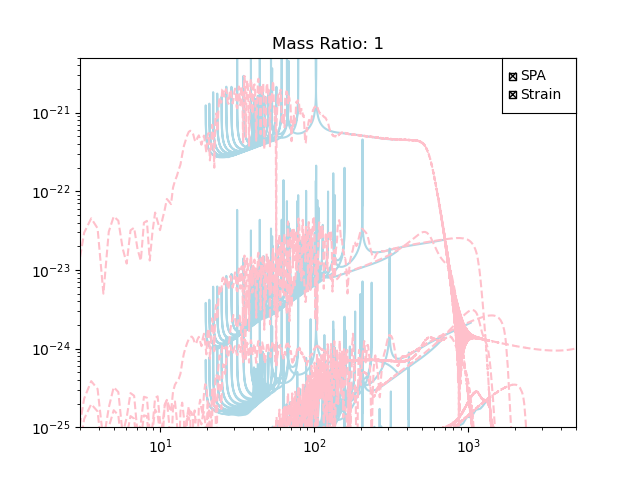

In [22]:
isxs.iplt_lm(h=h2612, t=t2612, metadata=metadata2612, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

# High <span style="color:lightblue">Precession</span> Examples #

Similarly to the high eccentricity plots, the SPA's here also won't be too helpful. 

## Example 3(a): BBH2442 (Mass Ratio: 1; High Precession)

In [23]:
metadata2442, h2442 = isxs.load_strain("2442")

  0%|                                                                   | 0/486 [00:00<?, ?it/s]

  0%|                                                               | 0/2854281 [00:00<?, ?it/s]

Mass ratio: 1.0000004198003536 
Reference eccentricity: 8.35e-05 
Reference Chi1_Perp (Precession): 0.9088730350466453 
Reference Chi2_Perp (Precession): 0.9094066102508338


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:2442,False,1.0,0.27528,0.908873,0.909407,0.000083,0.000083,1596.5,0.90295,-0.103918,...,"[-7.580496682807675, 1.0968455398e-06, -0.0068...",19.651297,19.651297,15.444943,"[, v2.0, v3.0]",[],2019-04-07 00:32:33,2019-06-22 14:55:55,2019-12-24 03:43:49,2025-01-28 15:14:21.877535


In [26]:
h2442, t2442 = isxs.dimensionalize(h2442, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


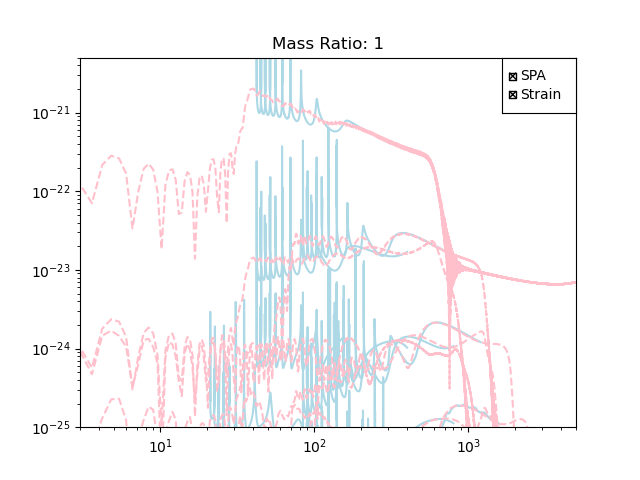

In [27]:
isxs.iplt_lm(h=h2442, t=t2442, metadata=metadata2442, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

SPA goes crazy! why? 
(lm modes are crazy too!)

## Example 3(b): BBH0832 (Mass Ratio: 2; High Precession)

In [28]:
metadata0832, h0832 = isxs.load_strain("BBH:0832")

  0%|                                                                   | 0/486 [00:00<?, ?it/s]

  0%|                                                               | 0/3760284 [00:00<?, ?it/s]

Mass ratio: 1.9999071505550408 
Reference eccentricity: 0.0006733 
Reference Chi1_Perp (Precession): 0.7978126276728859 
Reference Chi2_Perp (Precession): 0.7936788577883005


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:0832,False,1.999907,0.004935,0.797813,0.793679,0.000673,0.000673,1354.5,0.796805,0.005814,...,"[-9.99299019670823, 0.0224271903235236, 0.0060...",19.297684,19.297684,15.707471,"[, v1.2, v1.3, v1.4, v1.5, v2.0, v3.0]",[],2016-06-29 22:25:28,2016-07-30 03:07:15,2016-10-23 19:53:08,2025-01-28 14:53:35.928142


In [29]:
h0832, t0832 = isxs.dimensionalize(h0832, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


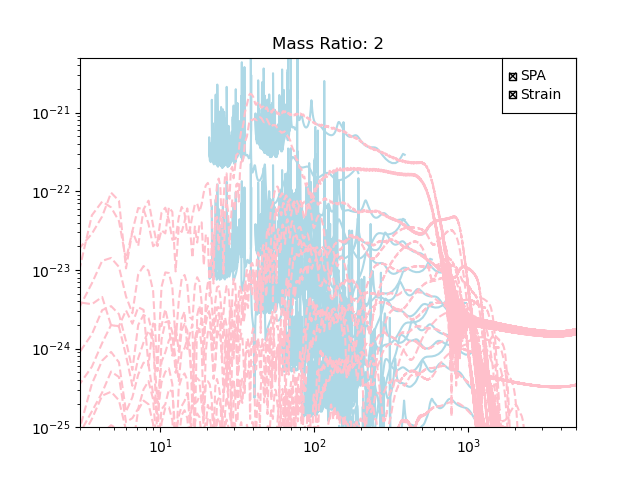

In [30]:
isxs.iplt_lm(h=h0832, t=t0832, metadata=metadata0832, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

## Example 3(c): BBH2443 (Mass Ratio: 1; High Precession)

In [31]:
metadata2443, h2443 = isxs.load_strain("BBH:2443")

  0%|                                                                   | 0/486 [00:00<?, ?it/s]

  0%|                                                               | 0/2972994 [00:00<?, ?it/s]

Mass ratio: 0.9999987604656909 
Reference eccentricity: 0.0001364 
Reference Chi1_Perp (Precession): 0.9100629212142324 
Reference Chi2_Perp (Precession): 0.9085648789228499


,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:2443,False,0.999999,0.274695,0.910063,0.908565,0.000136,0.000136,1580.5,-0.897685,0.15004,...,"[-7.579626849791353, -4.7006705109e-06, 0.0082...",19.649359,19.649359,15.487182,"[, v2.0, v3.0]",[],2019-04-07 00:32:33,2019-05-24 17:05:26,2019-12-04 22:03:49,2025-01-28 15:14:01.935797


In [33]:
h2443, t2443 = isxs.dimensionalize(h2443, G, c, M, r)

/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  htilde_lm = np.fft.rfft(hlm_line_subtracted.ndarray.astype(float))*dt
/home/fs01/jhc325/git/sxs-interactive/sxs_iplots.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  frequencies_lm = np.fft.rfftfreq(len(hlm_line_subtracted.ndarray.astype(float)), dt)


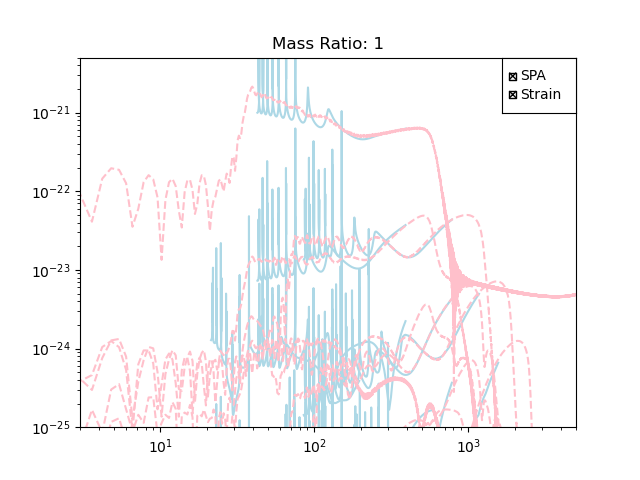

In [34]:
isxs.iplt_lm(h=h2443, t=t2443, metadata=metadata2443, cut=False)
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

Can use the metadata to make an if case for the eccentric case for extra padding

# Choose your own plot!

In [6]:
df = sxs.load("dataframe", tag="3.0.0")
df

,deprecated,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_eccentricity_bound,reference_time,reference_dimensionless_spin1_x,reference_dimensionless_spin1_y,...,initial_position2,number_of_orbits,number_of_orbits_from_start,number_of_orbits_from_reference_time,DOI_versions,keywords,date_link_earliest,date_run_earliest,date_run_latest,date_postprocessing
SXS:BBH:0001,True,1.000000,1.215639e-07,9.733309e-10,1.429939e-09,0.000257,0.000257,320.000000,7.097521e-10,-6.660518e-10,...,"[-8.999999874197535, -2.86646421e-08, 0.0]",28.119083,NaN,NaN,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v1.6, v2.0]","[Non-Spinning, ManyMergers-QuasiCircular, depr...",2012-07-31 17:17:11,2012-08-01 01:46:59,2012-08-17 20:48:06,2019-03-30 13:41:50
SXS:BBH:0002,True,1.000000,9.399402e-08,7.181763e-10,1.473155e-09,0.000175,0.000175,310.000000,6.507563e-10,-3.037983e-10,...,"[-9.49999971865619, 2.0830027e-07, 0.0]",32.421068,NaN,NaN,"[, v1.1, v1.2, v1.4, v1.5, v1.6, v1.7, v2.0]","[Non-Spinning, ManyMergers-QuasiCircular, depr...",2012-07-31 17:17:11,2012-08-01 02:24:21,2012-08-26 06:41:57,2019-03-30 13:41:50
SXS:BBH:0003,True,1.000440,2.707179e-04,4.993912e-01,7.428880e-08,0.000287,0.000287,210.000000,4.965977e-01,5.274908e-02,...,"[-9.507365032939443, -0.0023408782825215, 0.0]",32.337574,NaN,NaN,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v2.0]","[Precessing-Spins, ManyMergers-QuasiCircular, ...",2012-08-07 19:02:51,2012-08-18 20:24:58,2012-08-22 10:48:06,2019-03-30 13:41:50
SXS:BBH:0004,True,1.000459,-2.498083e-01,5.018106e-11,1.402755e-09,0.000380,0.000380,640.000000,-2.424428e-12,-1.449169e-11,...,"[-9.50286409695725, 0.0031879777731917, 0.0]",30.188749,NaN,NaN,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v2.0]","[Aligned-Spins, ManyMergers-QuasiCircular, dep...",2012-08-07 19:02:51,2012-08-18 20:24:58,2012-08-25 10:38:13,2019-03-30 13:41:50
SXS:BBH:0005,True,1.000460,2.498115e-01,6.905084e-11,2.745050e-09,0.000236,0.000236,390.000000,-3.646774e-12,1.616084e-11,...,"[-9.01162380399282, -0.0070599738280454, 0.0]",30.190238,NaN,NaN,"[, v1.1, v1.2, v1.3, v1.4, v1.5, v2.0]","[Aligned-Spins, ManyMergers-QuasiCircular, dep...",2012-08-07 19:02:51,2012-08-17 05:20:02,2012-08-28 09:11:15,2019-03-30 13:41:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SXS:NSNS:0006,False,1.199984,0.000000e+00,0.000000e+00,0.000000e+00,0.000160,0.000160,363.175161,0.000000e+00,0.000000e+00,...,"[20.1881, 0.000300831, 0.0]",NaN,NaN,NaN,NaN,[],2022-06-09 20:57:46,2022-06-22 14:35:12,2022-06-22 14:42:52,2023-09-26 23:00:19
SXS:NSNS:0007,False,0.831025,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,363.158338,0.000000e+00,0.000000e+00,...,"[16.3414, -0.000239926, 0.0]",NaN,NaN,NaN,NaN,[],2020-04-13 20:55:51,2020-11-30 13:36:56,2020-11-30 14:14:49,2023-10-04 21:50:19
SXS:NSNS:0008,False,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.001317,0.001317,359.961309,0.000000e+00,0.000000e+00,...,"[18.5, -0.000297416, 0.0]",NaN,NaN,NaN,NaN,[],2022-06-09 19:14:59,2022-06-17 13:10:13,2022-06-17 13:17:17,2023-09-26 23:00:19
SXS:NSNS:0009,False,1.099992,0.000000e+00,0.000000e+00,0.000000e+00,0.000920,0.000920,360.634903,0.000000e+00,0.000000e+00,...,"[19.3833, -0.000276636, 0.0]",NaN,NaN,NaN,NaN,[],2022-06-09 19:14:59,2022-06-17 13:05:03,2022-06-17 13:18:31,2023-09-26 23:00:19


In [5]:
isxs.chooseplot()

Output()

In [7]:
# Add the noise curves to the interactive plot
plt.loglog(ce_asd_amplitude, ce_asd_frequency, label="CE", color = "orange")
plt.loglog(ligo_o4_asd_amplitude, ligo_o4_asd_frequency, label="LIGO O4", color = "red")
plt.draw()

<font color='orange'> as of 6/5: First draft of the explanations I would say is more or less complete. I'm going to push everything onto github for review, and we'll see what to change/fix/add. In terms of other changes I'm thinking of adding: captions/labels of all the modes will be helpful, though I'm sure a pain to implement. Also make sure to just re-add all the other missing modes, not just the ones that'll appear above the noise curves initially. You can also change the initial mass/add more masses. I want to also figure out how to deal with all the deprecated simulations - be able to plot them or no? I also want to make the table interactive, but maybe we can worry about that when/if we push everything on marimo?